In [1]:
from google.colab import drive
drive.mount('/content/MyDrive')
%cd /content/MyDrive/MyDrive

Mounted at /content/MyDrive
/content/MyDrive/MyDrive


In [2]:
# importing the libraries
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from glob import glob
import pathlib
import datetime
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout


In [ ]:
# Raw Dataset Directory
training_data_dir = pathlib.Path("./flower_dataset/training")
validation_data_dir = pathlib.Path("./flower_dataset/validation")
testing_data_dir = pathlib.Path("./flower_dataset/testing")


training_image_count = len(list(training_data_dir.glob('*/*.jpg')))
validation_image_count = len(list(validation_data_dir.glob('*/*.jpg')))
testing_image_count = len(list(testing_data_dir.glob('*/*.jpg')))

# classnames in the dataset specified
CLASS_NAMES = np.array([item.name for item in training_data_dir.glob('*') ])

# print length of class names
output_class_units = len(CLASS_NAMES)
print('Total Classes = ' + str(output_class_units))

BATCH_SIZE = 32            # Can be of size 2^n, but not restricted to. for the better utilization of memory
IMG_HEIGHT = 224            # input Shape required by the model
IMG_WIDTH = 224             # input Shape required by the model
STEPS_PER_EPOCH = np.ceil(training_image_count/BATCH_SIZE)
VALIDATION_STEPS = np.ceil(validation_image_count/BATCH_SIZE)
TESTING_STEPS = np.ceil(testing_image_count/BATCH_SIZE)

# ImageDataGenerator for data augmentation and preprocessing
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Training Data Generator
train_data_gen = image_generator.flow_from_directory(
    directory=training_data_dir,
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical'
)

# Validation Data Generator
validation_data_gen = image_generator.flow_from_directory(
    directory=validation_data_dir,
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical'
)

# Testing Data Generator
testing_data_gen = image_generator.flow_from_directory(
    directory=testing_data_dir,
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical'
)

Total Classes = 5
Found 3457 images belonging to 5 classes.
Found 843 images belonging to 5 classes.
Found 17 images belonging to 5 classes.


In [ ]:
# The labels are stored in class_indices in dictionary form.
# checking the labels
train_data_gen.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [ ]:
# importing the libraries
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications import VGG16
from keras.layers import Dropout
from keras.optimizers import Adam
#from keras.preprocessing import image

IMAGE_SIZE = [224, 224]  # we will keep the image size as (64,64). You can increase the size for better results.

# loading the weights of VGG16 without the top layer. These weights are trained on Imagenet dataset.
vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)  # input_shape = (64,64,3) as required by VGG

# this will exclude the initial layers from training phase as there are already been trained.
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  # Add dropout for regularization
x = Dense(output_class_units, activation = 'softmax')(x)

model = Model(inputs=vgg.input, outputs=x)

# Use 'learning_rate' instead of 'lr' for the Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.00001), metrics=['accuracy'])


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Import necessary libraries

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

# Define a custom callback
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') == 1.00 and logs.get('loss') < 0.03:
            print("\nReached 100% accuracy and low loss, stopping training.")
            self.model.stop_training = True

# Instantiate the custom callback
my_callback = MyCallback()

# Early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the model weights to the best achieved during training
)

# Learning rate reduction callback
learning_rate_callback = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce the learning rate by half
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.00001       # Minimum learning rate
)

# TensorBoard visualization callback
log_dir = "VGG16/logs/" + "SDG optimizer with  epochs=100" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1  # Log histogram data for visualization
)


In [ ]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=100,
    validation_data=validation_data_gen,
    validation_steps=VALIDATION_STEPS,
    callbacks=[tensorboard_callback, early_stopping_callback]
)

# Saving the VGG16 model
model.save('VGG16/VGG16_trained_model/' + "SDG optimizer1 with  epochs=100" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

Epoch 1/100
109/109 [==============================] - 746s 7s/step - loss: 1.8913 - accuracy: 0.1634 - val_loss: 1.7143 - val_accuracy: 0.1601
Epoch 2/100
109/109 [==============================] - 21s 188ms/step - loss: 1.7635 - accuracy: 0.1906 - val_loss: 1.6473 - val_accuracy: 0.2040
Epoch 3/100
109/109 [==============================] - 21s 193ms/step - loss: 1.7083 - accuracy: 0.2129 - val_loss: 1.6218 - val_accuracy: 0.2622
Epoch 4/100
109/109 [==============================] - 20s 188ms/step - loss: 1.6796 - accuracy: 0.2251 - val_loss: 1.6060 - val_accuracy: 0.2859
Epoch 5/100
109/109 [==============================] - 20s 181ms/step - loss: 1.6770 - accuracy: 0.2349 - val_loss: 1.5925 - val_accuracy: 0.3096
Epoch 6/100
109/109 [==============================] - 20s 185ms/step - loss: 1.6507 - accuracy: 0.2560 - val_loss: 1.5802 - val_accuracy: 0.3179
Epoch 7/100
109/109 [==============================] - 21s 192ms/step - loss: 1.6377 - accuracy: 0.2612 - val_loss: 1.5691 - v

In [ ]:
# Load the TensorBoard notebook extension.

%load_ext tensorboard
%tensorboard --logdir MobileNet/logs/flowers_dataset_try_1_rmsprop_optimzer --port=8039


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

In [ ]:
model.evaluate(testing_data_gen)

1/1 [==============================] - 0s 111ms/step - loss: 0.5168 - accuracy: 0.8824


[0.5167506337165833, 0.8823529481887817]

In [ ]:
new_model = tf.keras.models.load_model('VGG16/VGG16_trained_model/20230930-133729')
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

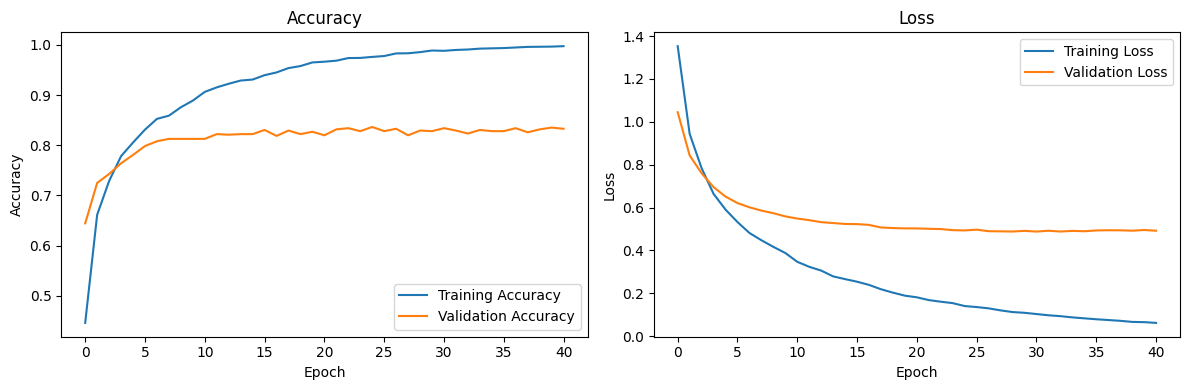

In [ ]:
# Access training and validation accuracy and loss values from the history object
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess a single image
# image_path = './flower_dataset/testing/daisy/2666572212_2caca8de9f_n.jpg'
# image_path = './flower_dataset/testing/daisy/7702332000_3f21ef4571_n.jpg'
image_path = './flower_dataset/testing/dandelion/20456824132_b1c8fbfa41_m.jpg'
img = image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))  # Adjust target_size as needed
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize the image data (if needed)

# Make a prediction
predictions = new_model.predict(img_array)
print(predictions)


# Convert predicted probabilities to class labels
predicted_label_idx = np.argmax(predictions, axis=1)[0]
idx_to_cls = {v: k for k, v in train_data_gen.class_indices.items()}

preds_cls = np.vectorize(idx_to_cls.get)(predicted_label_idx)
accuracy = predictions[0][predicted_label_idx]*100


print('Class: {}'.format(preds_cls))
print('Accuracy: {}%'.format(accuracy))

NameError: ignored